Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality, Duration And Cyclic Time

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
############################
#SAMPLE
dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
df = dfa.sample(n=30000, random_state=1).copy()

#df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,2,0,7.071068e-01,0.707107,0.974928,-0.222521
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,4,0,-8.660254e-01,-0.500000,-0.433884,-0.900969
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,5,1,-8.660254e-01,0.500000,-0.974928,-0.222521
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,3,0,-2.588190e-01,-0.965926,0.433884,-0.900969
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,5,1,-8.660254e-01,0.500000,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667,15,4,0,-7.071068e-01,-0.707107,-0.433884,-0.900969
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667,12,4,0,1.224647e-16,-1.000000,-0.433884,-0.900969
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667,14,6,1,-5.000000e-01,-0.866025,-0.781831,0.623490
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667,15,0,0,-7.071068e-01,-0.707107,0.000000,1.000000


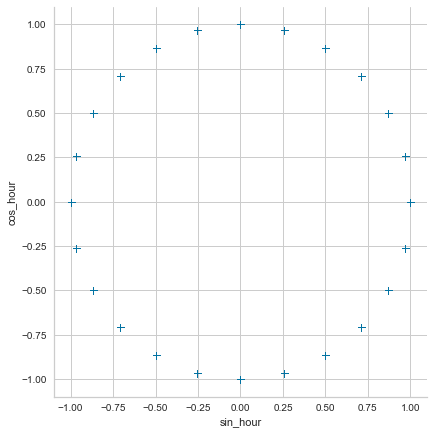

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

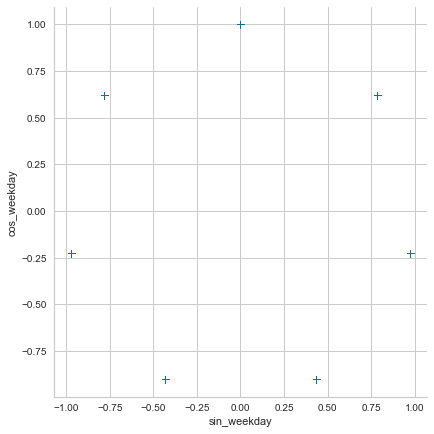

In [7]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

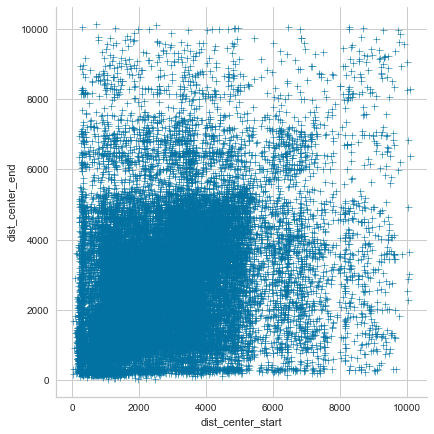

In [8]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
#df = df.drop(df[(df['dist_center_start']>11000)&(df['dist_center_end']>11000)].index, inplace=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'weekend'),
  Text(6, 0, 'sin_hour'),
  Text(7, 0, 'cos_hour'),
  Text(8, 0, 'sin_weekday'),
  Text(9, 0, 'cos_weekday')])

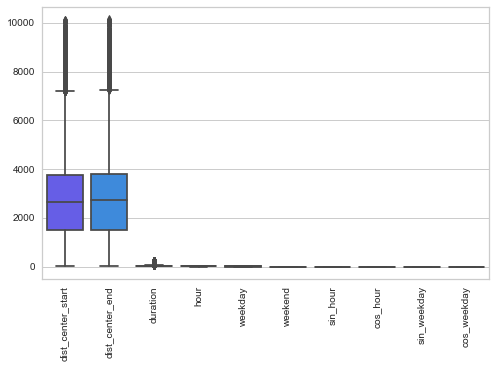

In [9]:
# look at feature skewness
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [16]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(.5 * (1 - .5)))

qqqq=df[['dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
selector.fit_transform(qqqq)
qqqq

,dist_center_start,dist_center_end,duration,hour,weekday,weekend
0,1986,3290,20.000000,3,2,0
1,4756,1625,50.016667,16,4,0
2,4353,525,40.000000,20,5,1
3,2169,2844,30.000000,13,3,0
4,1586,2935,25.033333,20,5,1
...,...,...,...,...,...,...
29732,1384,1149,64.716667,15,4,0
29733,4465,4396,9.966667,12,4,0
29734,3646,571,25.016667,14,6,1
29735,1970,3675,50.016667,15,0,0


In [10]:
# normalize features to get same range as sin and cos values
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

#dfnorm = df[['dist_center_start','dist_center_end', 'duration']].copy()

dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 1.7

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1.5

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.515453
cos_hour             0.384324
sin_weekday          0.223187
cos_weekday          0.218933
dist_center_start    0.546206
dist_center_end      0.555926
duration             0.455233
weekend              0.147062
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration'),
  Text(7, 0, 'weekend')])

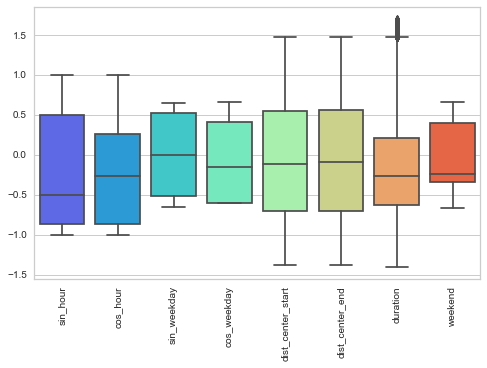

In [11]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

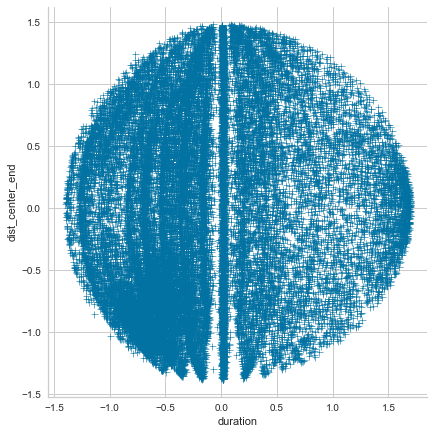

In [12]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="duration", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=6, aspect=1)

### Cluster tendency

In [13]:
# calculate hopkins statistics on subset
from pyclustertend import hopkins
#hopkins(scaled_df, 10000)

### Clustering trip types via k-means and parameter selection

#### Parameter selection / clustering performance evaluation

In [14]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

max_num_cluster = 40

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  74368.205854772
silhouette:  0.17316206638905352
calinski harabasz:  6484.2490077295315
davies bouldin:  2.1176628294738795
19.2640380859375
3
inertia:  66513.25722818144
silhouette:  0.15763884111426413
calinski harabasz:  5380.627996700905
davies bouldin:  2.0451076354523
17.50631594657898
4
inertia:  60394.48479994296
silhouette:  0.1519197960932004
calinski harabasz:  4954.513659410922
davies bouldin:  1.9626366902934906
16.285478591918945
5
inertia:  55544.97091577276
silhouette:  0.16025050206227243
calinski harabasz:  4689.131546662587
davies bouldin:  1.8491289938597042
18.417137145996094
6
inertia:  51813.15608328912
silhouette:  0.16497415264921494
calinski harabasz:  4449.627032562617
davies bouldin:  1.760447427993909
18.339542150497437
7
inertia:  48745.18744225783
silhouette:  0.16589478255812984
calinski harabasz:  4253.136123721328
davies bouldin:  1.6471805926363392
16.95469570159912
8
inertia:  46188.780569096896
silhouette:  0.16844505014098396
calinski h

#### Elbow method

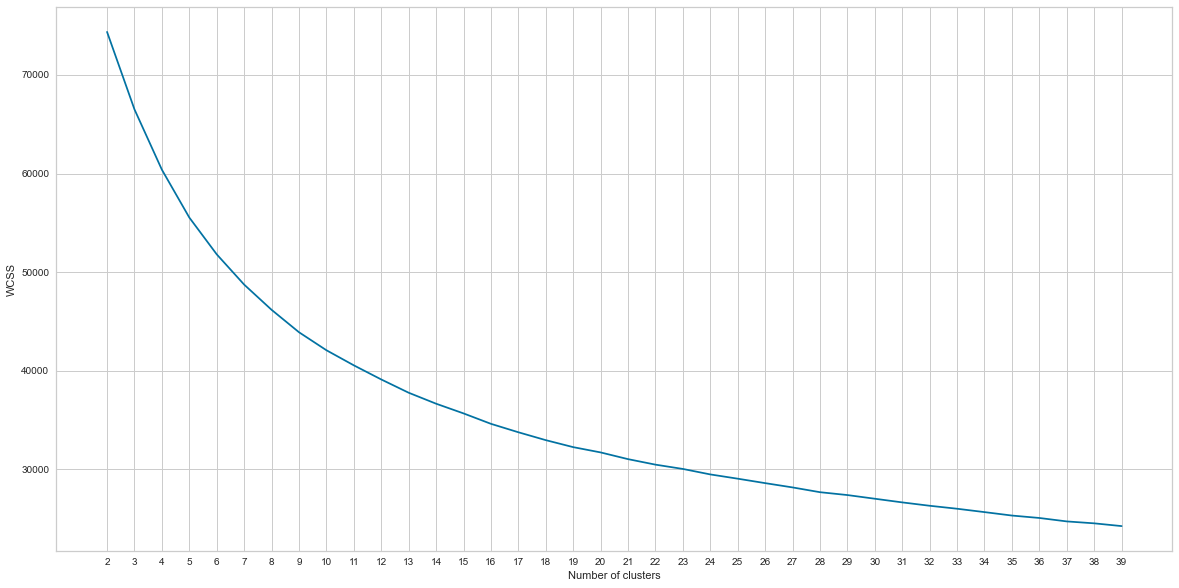

In [15]:
# plot wcss for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

#### Silhouette coefficient

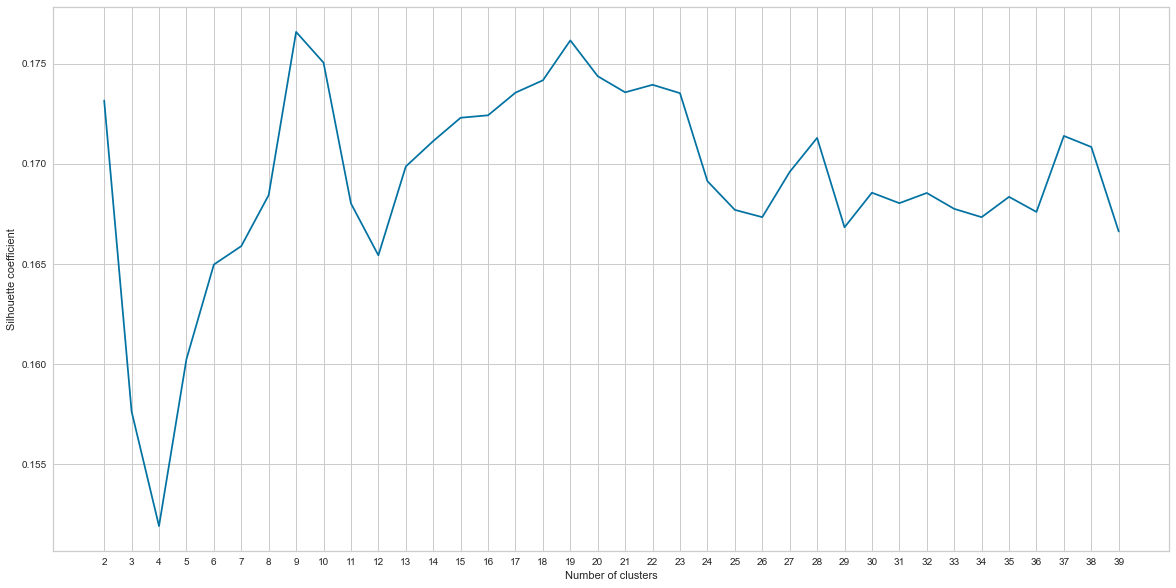

In [16]:
# plot silhouette coefficients for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

In [17]:
# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,40), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

#### Calinski Harabasz score

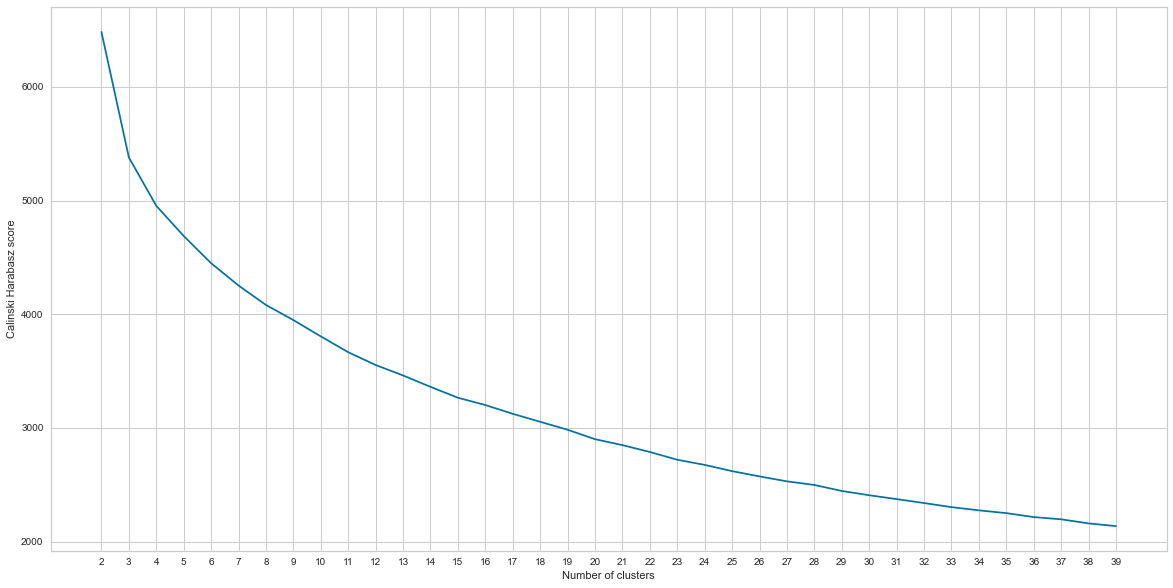

In [18]:
# plot Calinski Harabasz score for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()

#### Davies Bouldin index

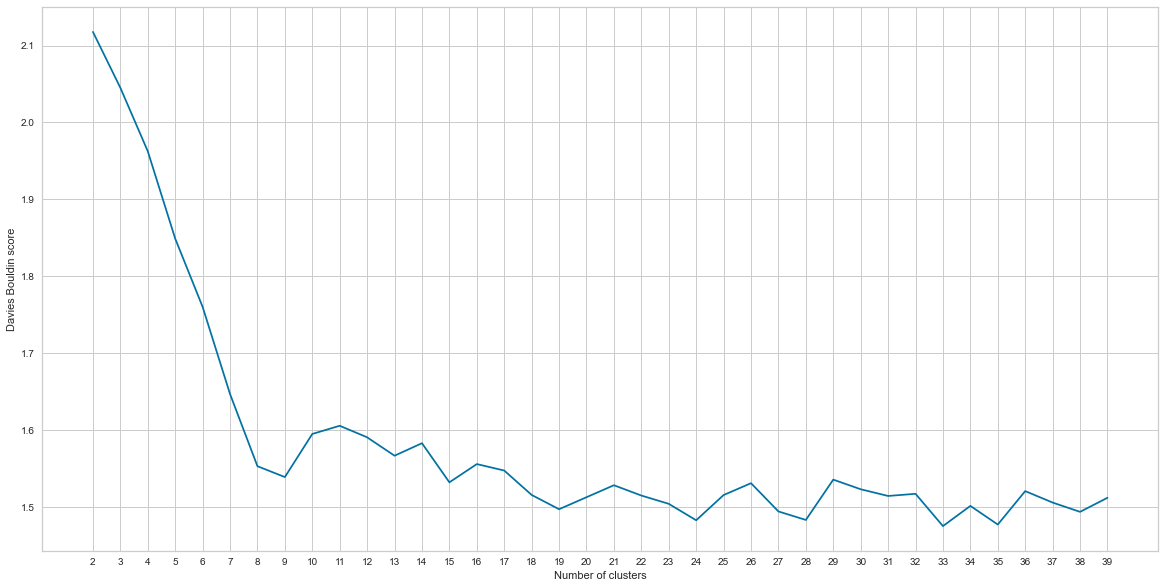

In [19]:
# plot Davies Bouldin scores for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()

#### K-means with selected parameter

In [20]:
# cluster data for the chosen number of clusters
k = 19

kmeans = KMeans(n_clusters=k,  n_init=20, random_state=0).fit(scaled_df)

clustered_data = df.copy()

clustered_data['cluster'] = kmeans.fit_predict(scaled_df)


clustered_data

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,2,0,7.071068e-01,0.707107,0.974928,-0.222521,3
1,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,4,0,-8.660254e-01,-0.500000,-0.433884,-0.900969,18
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,5,1,-8.660254e-01,0.500000,-0.974928,-0.222521,4
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,3,0,-2.588190e-01,-0.965926,0.433884,-0.900969,1
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,5,1,-8.660254e-01,0.500000,-0.974928,-0.222521,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29732,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667,15,4,0,-7.071068e-01,-0.707107,-0.433884,-0.900969,16
29733,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667,12,4,0,1.224647e-16,-1.000000,-0.433884,-0.900969,0
29734,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667,14,6,1,-5.000000e-01,-0.866025,-0.781831,0.623490,9
29735,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667,15,0,0,-7.071068e-01,-0.707107,0.000000,1.000000,16


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

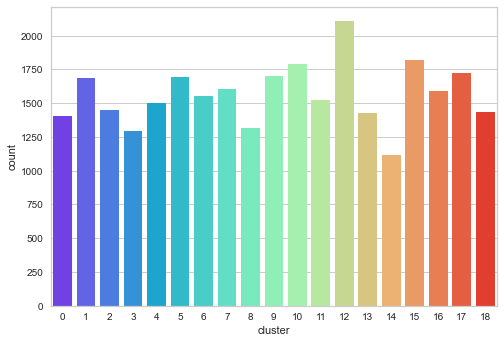

In [21]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Cluster magnitude

In [22]:

#distances = kmeans.fit_transform(scaled_df)
#variance = 0
#i = 0
#for label in kmeans.labels_:
#    variance = variance + distances[i][label]
#    i = i + 1
#variance

#for kmeans.labels_
#inertia_0

#### Cardinality vs magnitude

#### Attribute table

In [23]:
interpret_df = clustered_data[['dist_center_start','dist_center_end','duration', 'weekend','cluster']].copy()
interpret_df = interpret_df.groupby(['cluster']).mean()


time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

interpret_df = interpret_df.join(time_df)

interpret_df['morning 6-12'] = interpret_df[6] + interpret_df[7] + interpret_df[8] + interpret_df[9] + interpret_df[10] + interpret_df[11] + interpret_df[12]
interpret_df['evening 13-20'] = interpret_df[14] + interpret_df[15] + interpret_df[16] + interpret_df[17] + interpret_df[18] + interpret_df[19] + interpret_df[20]


pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret = interpret_df
#interpret_df.T.round(2).to_excel("1-InterpretClusters.xlsx")  
#interpret = interpret[(interpret['dist_center_start']>3000)&(interpret['dist_center_end']>3000)]
interpret.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
dist_center_start,3262.65,1461.32,2286.75,1951.52,4448.64,1656.66,4130.72,5096.15,3675.40,1889.40,1511.80,4614.10,1568.45,4329.37,2970.11,1583.76,2893.42,1678.59,4568.08
dist_center_end,3398.20,1524.16,2760.26,5170.25,3358.62,1825.72,4195.52,4718.74,4473.25,1672.85,1587.80,4281.87,1579.25,1298.02,2822.23,4483.60,2873.21,1927.85,1662.26
duration,12.52,17.55,19.00,34.40,28.65,16.31,19.01,33.25,28.71,21.08,17.74,23.91,15.90,32.22,97.23,31.21,87.13,21.31,33.21
weekend,0.00,0.00,0.99,0.03,1.00,0.00,0.03,0.01,0.99,1.00,0.00,0.02,0.02,0.09,0.16,0.06,0.19,1.00,0.00
0 Monday,17.62,0.00,0.76,19.91,0.00,12.46,18.63,17.58,0.00,0.06,38.04,18.02,20.11,15.98,14.02,17.00,14.03,0.00,16.89
1 Tuesday,19.40,0.00,0.00,20.37,0.00,14.17,17.28,18.20,0.00,0.00,38.20,19.79,23.58,16.40,17.14,16.61,14.73,0.00,16.68
2 Wednesday,19.90,8.01,0.00,17.36,0.00,21.37,18.96,21.76,0.00,0.00,23.76,18.68,18.60,19.69,15.09,16.72,13.47,0.00,19.19
3 Thursday,20.76,37.39,0.00,20.06,0.00,20.84,17.92,19.70,0.00,0.00,0.00,22.35,19.40,19.20,17.41,21.56,15.98,0.00,19.96
4 Friday,22.33,54.60,0.48,18.98,0.00,31.17,24.63,21.88,0.99,0.00,0.00,19.00,16.60,19.90,19.91,21.89,22.66,0.00,27.08
5 Saturday,0.00,0.00,56.90,1.62,62.67,0.00,1.55,0.37,56.79,58.35,0.00,1.38,0.28,4.91,11.16,3.30,11.58,62.02,0.21


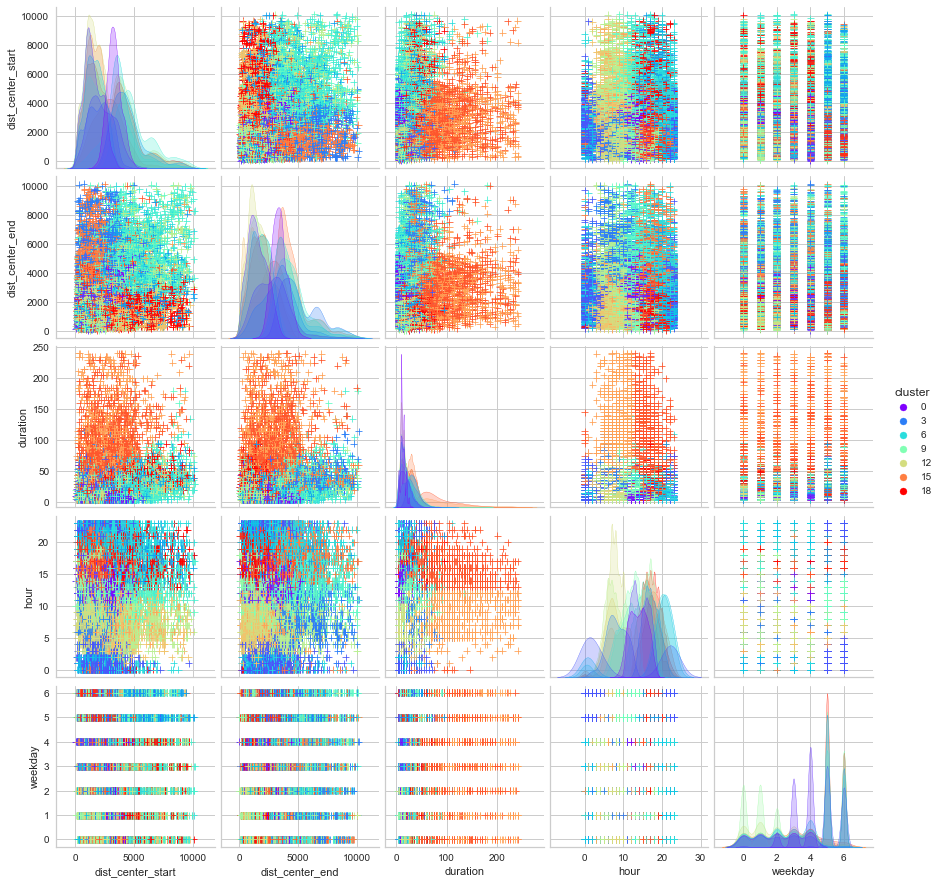

In [24]:
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=0.8), palette='rainbow')

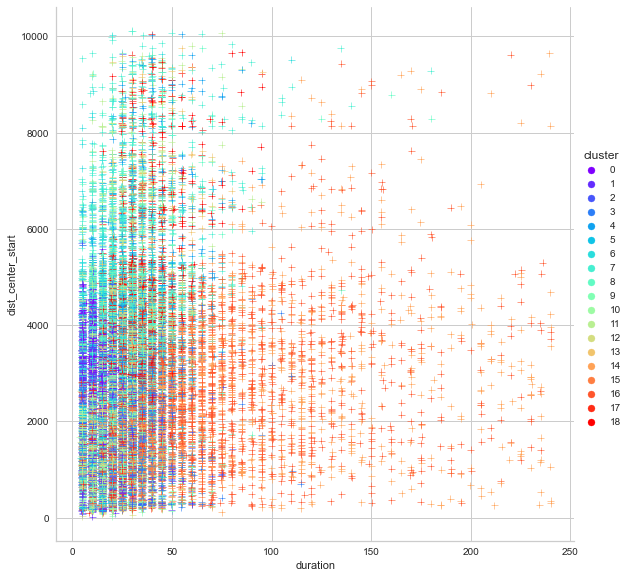

In [25]:
# plot cluster results
g = sns.relplot(x="duration", y="dist_center_start", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

<AxesSubplot:xlabel='weekday', ylabel='count'>

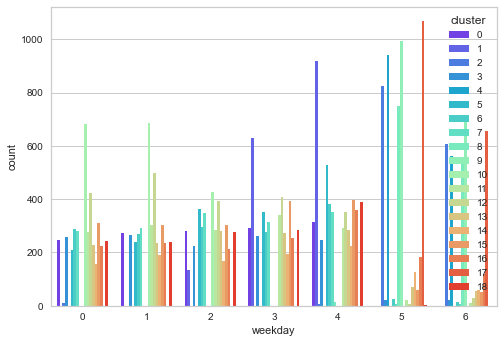

In [26]:
sns.countplot(x="weekday", data=clustered_data, hue='cluster', palette='rainbow')

In [27]:
sampleTSNE = scaled_df.sample(n=5000, random_state=1)
# cluster data for the chosen number of clusters
k = 19
k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
clusters = k_means_new.fit_predict(sampleTSNE)
sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,:-1]
##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.012s...
[t-SNE] Computed neighbors for 5000 samples in 0.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.569769
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.268440
[t-SNE] KL divergence after 5000 iterations: 1.264304


array([[  3.013253 , -10.140794 ],
       [ 27.313337 , -46.269444 ],
       [  1.9953197, -17.585976 ],
       ...,
       [ 25.546356 ,  44.8956   ],
       [-15.998047 , -10.427569 ],
       [ 29.724949 , -34.324806 ]], dtype=float32)

In [28]:
tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = clusters
tsne_cluster.columns = ['x1','x2','cluster']

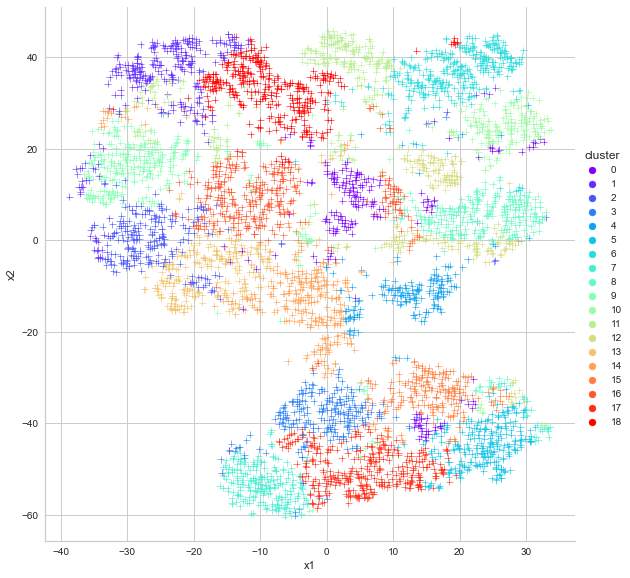

In [29]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=8, aspect=1)

### Distribution of trip types among mobility modes

In [30]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [31]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,1.797240
1,2.748720
2,3.761407
3,6.599154
4,6.231916
5,3.138215
6,5.141331
7,7.817716
8,5.519697


In [32]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,7.413167
1,8.864697
2,4.872991
3,2.177294
4,2.695697
5,7.516848
6,3.680664
7,1.555210
8,3.058580


In [33]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,9.516063
1,10.370069
2,6.913379
3,0.691338
4,3.334689
5,10.014233
6,5.652704
7,1.718178
8,2.724685
